코드 참조 사이트 : https://data-science-hi.tistory.com/190

LSTM : https://pytorch.org/docs/master/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM

In [1]:
#데이터 경로 : /content/drive/MyDrive/kospi.csv

In [2]:
#module import
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [4]:
#dataset 불러오기 
df = pd.read_csv('/content/drive/MyDrive/kospi.csv')
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400


In [5]:
#Normalization using MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609


In [6]:
#device settings
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [7]:
#split data into target and features
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [8]:
def seq_data(x,y,sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])
  
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1,1])

In [10]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [11]:
#batch formation
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20

train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size , shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size , shuffle = False)

In [14]:
#RNN : 입력 노드 수, 레이어 개수, hidden state 크기
input_size = x_seq.size(2) #features 의 개수
num_layers = 2
hidden_size = 8

In [36]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size,hidden_size, sequence_length, num_layers, device):
    super(CustomLSTM,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size,hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length,1), nn.Sigmoid())
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 cell state 설정하기.
    out, _ = self.lstm(x, (h0, c0)) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out

In [37]:
model = CustomLSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [38]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(),lr = lr)

In [39]:
#model train

loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:
    seq, target = data
    output = model(seq)
    loss = criterion(output, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_graph.append(running_loss / n)

  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.0254
[epoch: 100] loss: 0.0055


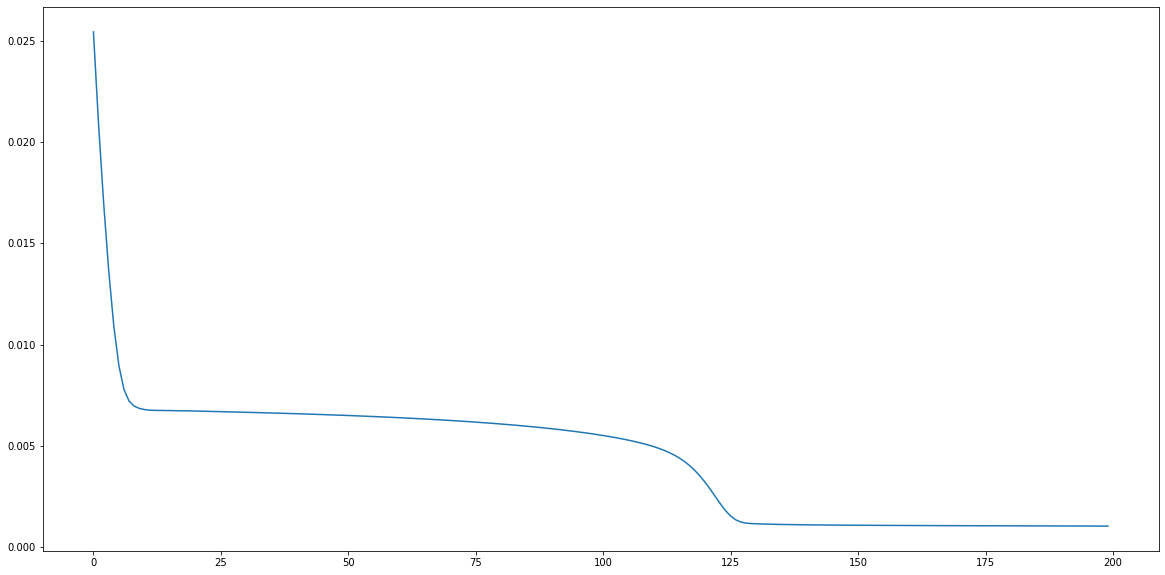

In [40]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

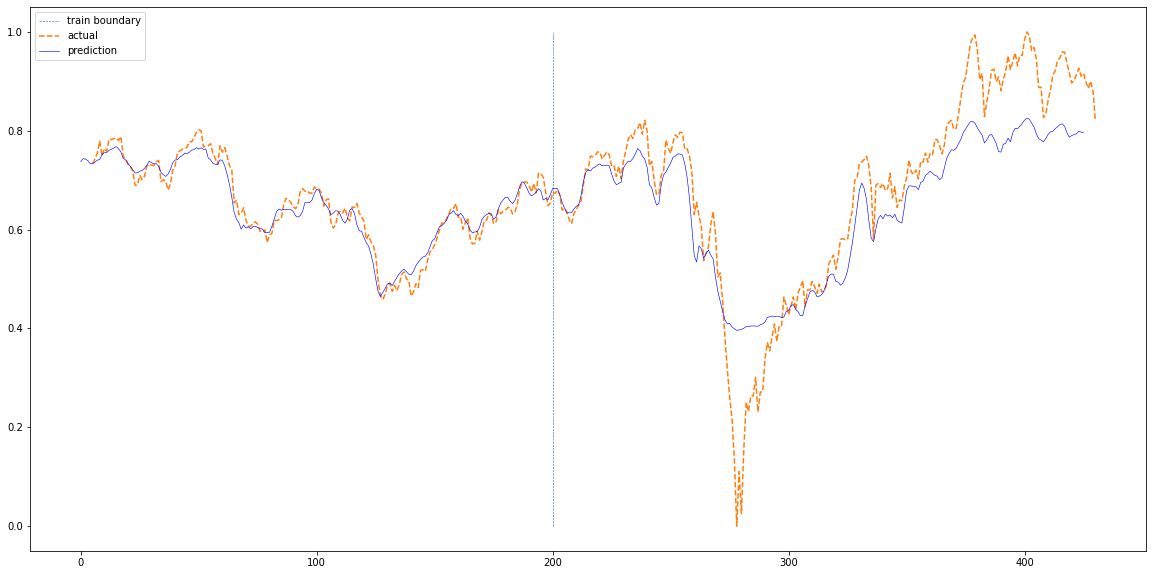

In [41]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length:])

팍 떨어지는 부분을 잘 예측하지 못한 경우가 있다.